<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/nifty_%25_above_50_dma(using_savitsky_golay_filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
from scipy.signal import savgol_filter

In [34]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
nifty_stocks = tickers

def calculate_percentage_above_moving_average(stock_list,periods,start_date):
    data = yf.download(stock_list, start=start_date)
    data = data['Adj Close']

    # Calculate the moving average using ewm with min_periods set to 50
    #ma = data.ewm(span=periods, min_periods=periods).mean()
    ma = data.ewm(span=periods, min_periods=periods).mean()
    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(stock_list)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,'2020-05-01')
percentage_50_dma=calculate_percentage_above_moving_average(nifty_stocks,50,'2020-05-01')
# Download the Bank Nifty index data
nifty = yf.download('^NSEI', start='2020-05-01')

# Reindex Bank Nifty index data to match percentage_above_dma
aligned_nifty_close = nifty['Adj Close'].reindex(percentage_above_dma.index)




[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


In [52]:
percentage_above_dma_30_ema=savgol_filter(percentage_50_dma, window_length = 50, polyorder = 5)
percentage_above_dma_10_ema=savgol_filter(percentage_50_dma, window_length = 10, polyorder = 5)

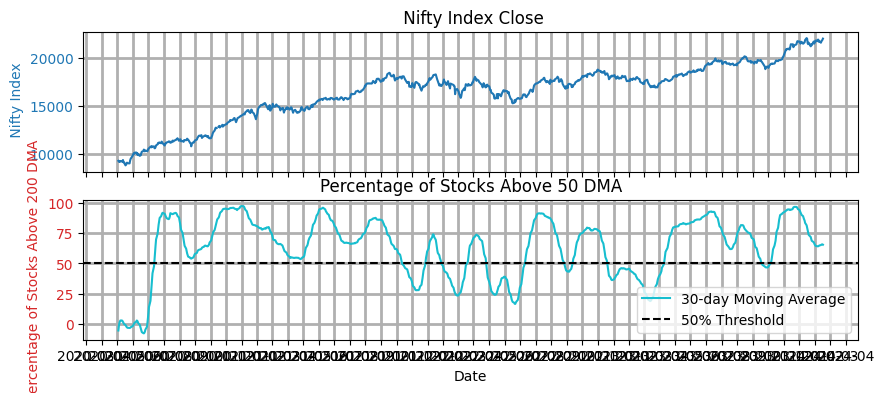

In [53]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
#ax2.plot(percentage_above_dma.index, percentage_above_dma_10_ema, color='tab:red', label='Percentage Above 200 DMA')
ax2.plot(percentage_50_dma.index, percentage_above_dma_30_ema, color='tab:cyan', label='30-day Moving Average')
#ax2.plot(percentage_50_dma.index, percentage_above_dma_10_ema, color='tab:red', label='30-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
ax2.legend()

yloc = YearLocator()
mloc = MonthLocator()
ax1.xaxis.set_major_locator(mloc)
ax2.xaxis.set_major_locator(mloc)
#ax[2].xaxis.set_major_locator(mloc)
ax1.grid(linewidth =2)
ax2.grid(linewidth =2)
#ax[2].grid(linewidth =2)


plt.show()


In [37]:
signal=np.where(percentage_above_dma_10_ema>percentage_above_dma_30_ema,1,0)
result=percentage_above_dma_10_ema-percentage_above_dma_30_ema

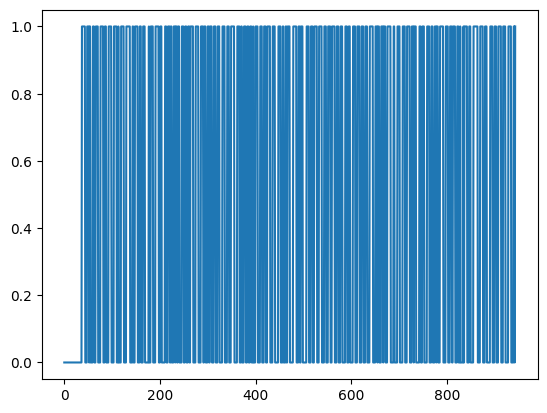

In [38]:
pd.Series(signal).plot();

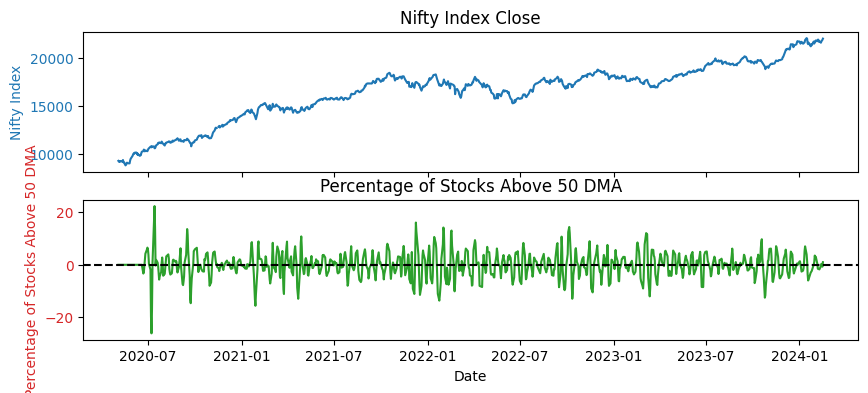

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel('Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 50 DMA', color='tab:red')
ax2.plot(percentage_50_dma.index,result, color='tab:green', label='Percentage Above 50 DMA-(30ema-10ema) smoothing everage')

ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=0, color='black', linestyle='dashed', label='50% Threshold')
#ax2.axhline(y=-20, color='green', label='buy here or at Divergence')
#ax2.legend(loc='upper left')
plt.show()


In [40]:
#pd.concat(aligned_nifty_close,result)
result_df = pd.concat([aligned_nifty_close, percentage_50_dma], axis=1)
result_df.columns = ['Nifty_Close', 'Pct_Above_DMA10']
result_df.reset_index(inplace=True)

In [41]:
signal[-5:]

array([0, 1, 1, 0, 1])

In [42]:
result[-5:]

array([-0.55750096,  0.38276137,  0.15311966, -0.70779875,  0.99302557])

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [44]:
regre= pd.DataFrame()

In [45]:
# Calculate the 15-day moving average
regre['MA_15'] = result

# Calculate 15-day returns
regre['Returns_15'] = aligned_nifty_close.pct_change(periods=15)

# Drop NaN values
regre = regre.dropna()

# Prepare data for regression
X = regre[['MA_15']]
y = regre['Returns_15']

# Train linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict returns using the regression line
regre['Predicted_Returns'] = model.predict(X)

# Plot the results
plt.figure(figsize=(10, 6))

plt.scatter(regre['MA_15'], regre['Returns_15'], label='Actual Returns', alpha=0.7)
plt.plot(regre['MA_15'], regre['Predicted_Returns'], color='red', label='Regression Line')

plt.title('Regression Line of 15-day Moving Average and 15-day Returns')
plt.xlabel('15-day Moving Average')
plt.ylabel('15-day Returns')
plt.legend()
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
def find_median_return_for_rsi(data, rsi_value):
    similar_rsi = data[np.isclose(data['Pct_Above_DMA10'], rsi_value,rtol=0.05)]#2%--> 0.02
    future_returns = similar_rsi['Future_Return']  # Assumes 'Future_Return' is calculated
    median_return = future_returns.median()
    return median_return*100

# Pre-calculate future returns
result_df['Future_Return'] = result_df['Nifty_Close'].pct_change(periods=5).shift(-5)

# Example Usage
todays_date = pd.to_datetime('2023-02-11')
closest_date = result_df[result_df['Date'] <= todays_date]['Date'].max()
todays_parameter = result_df.loc[result_df['Date'] == closest_date, 'Pct_Above_DMA10'].iloc[0]



median_return = find_median_return_for_rsi(result_df, todays_parameter)

print("Median 5-day Nifty return for similar 10-ema of nifty 50 stocks :", median_return)
